In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [2]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip  'readme[1].txt'
 image-classifier.ipynb    PetImages		        save_at_1.keras


In [2]:
!ls PetImages

1.jpg  2.jpg  Cat  Dog


In [3]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [4]:
image_size = (90, 90)
batch_size = 128

In [5]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


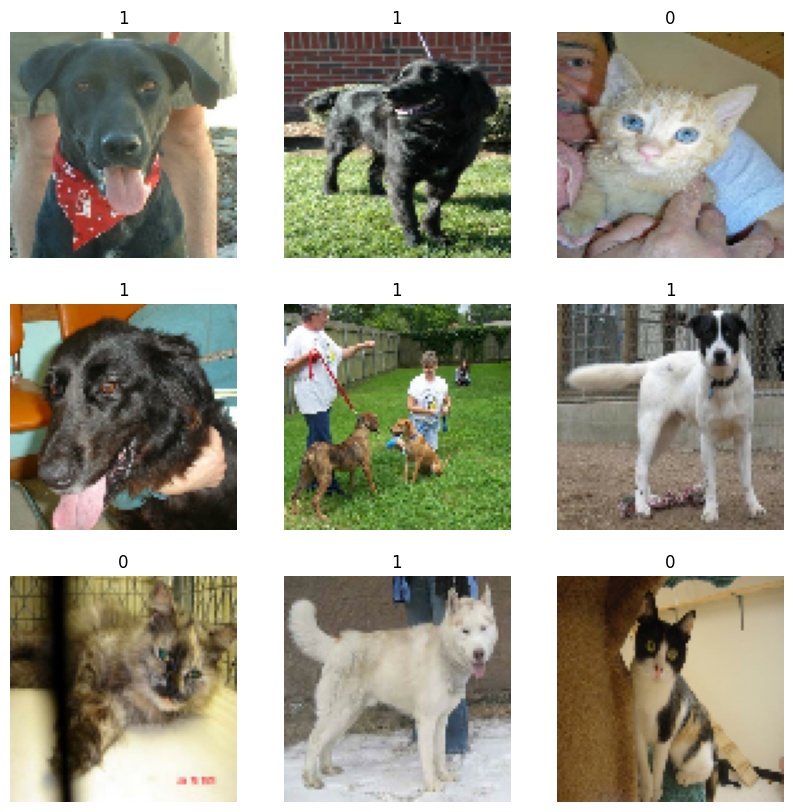

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1)
    ]
)

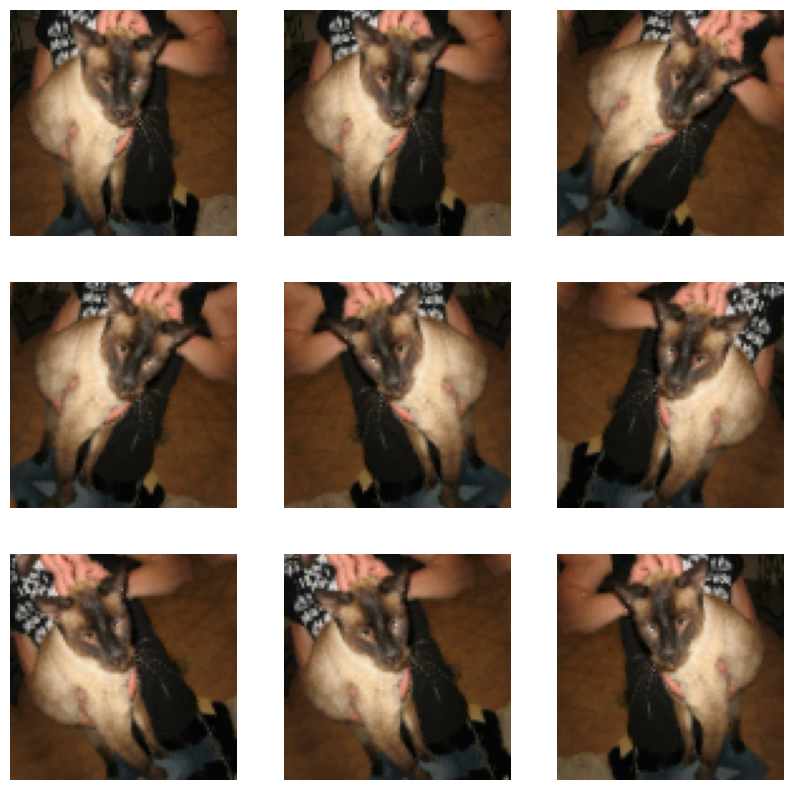

In [8]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)

In [9]:
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [10]:
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

2023-07-22 00:32:08.919721: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132710400 exceeds 10% of free system memory.
2023-07-22 00:32:08.997953: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132710400 exceeds 10% of free system memory.
2023-07-22 00:32:09.147128: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132710400 exceeds 10% of free system memory.
2023-07-22 00:32:09.219915: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132710400 exceeds 10% of free system memory.
2023-07-22 00:32:09.324441: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 265420800 exceeds 10% of free system memory.


147/147 [==============================] - 1111s 8s/step - loss: 0.6305 - accuracy: 0.6625 - val_loss: 0.6929 - val_accuracy: 0.5043


In [14]:
model.fit(
    train_ds,
    epochs=10,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/10
147/147 [==============================] - 1225s 8s/step - loss: 0.4579 - accuracy: 0.7847 - val_loss: 0.8106 - val_accuracy: 0.4957
Epoch 2/10
147/147 [==============================] - 1184s 8s/step - loss: 0.3642 - accuracy: 0.8358 - val_loss: 0.7748 - val_accuracy: 0.4957
Epoch 3/10
147/147 [==============================] - 1160s 8s/step - loss: 0.3153 - accuracy: 0.8625 - val_loss: 0.5151 - val_accuracy: 0.7206
Epoch 4/10
147/147 [==============================] - 1065s 7s/step - loss: 0.2752 - accuracy: 0.8827 - val_loss: 0.3005 - val_accuracy: 0.8718
Epoch 5/10
147/147 [==============================] - 1039s 7s/step - loss: 0.2498 - accuracy: 0.8950 - val_loss: 0.2782 - val_accuracy: 0.8815
Epoch 6/10
147/147 [==============================] - 1037s 7s/step - loss: 0.2286 - accuracy: 0.9037 - val_loss: 0.3092 - val_accuracy: 0.8663
Epoch 7/10
147/147 [==============================] - 1038s 7s/step - loss: 0.2146 - accuracy: 0.9118 - val_loss: 0.2552 - val_accuracy:

In [15]:
model.fit(
    train_ds,
    epochs=2,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/2
147/147 [==============================] - 1139s 8s/step - loss: 0.1667 - accuracy: 0.9316 - val_loss: 0.3491 - val_accuracy: 0.8445
Epoch 2/2
147/147 [==============================] - 1248s 8s/step - loss: 0.1634 - accuracy: 0.9307 - val_loss: 0.2183 - val_accuracy: 0.9086


In [16]:
model.fit(
    train_ds,
    epochs=1,
    callbacks=callbacks,
    validation_data=val_ds
)

147/147 [==============================] - 1307s 9s/step - loss: 0.1587 - accuracy: 0.9334 - val_loss: 0.2093 - val_accuracy: 0.9210


In [17]:
model.fit(
    train_ds,
    epochs=1,
    callbacks=callbacks,
    validation_data=val_ds
)

147/147 [==============================] - 1166s 8s/step - loss: 0.1493 - accuracy: 0.9397 - val_loss: 0.3491 - val_accuracy: 0.8616


In [18]:
model.fit(
    train_ds,
    epochs=1,
    callbacks=callbacks,
    validation_data=val_ds
)

147/147 [==============================] - 1129s 8s/step - loss: 0.1420 - accuracy: 0.9419 - val_loss: 0.2005 - val_accuracy: 0.9156


In [17]:
model.fit(
    train_ds,
    epochs=1,
    callbacks=callbacks,
    validation_data=val_ds
)

 38/147 [======>.......................] - ETA: 13:06 - loss: 0.6857 - accuracy: 0.6143

KeyboardInterrupt: 

In [19]:
model.load_weights(filepath="save_at_10.keras")

In [21]:
img = keras.utils.load_img(
    "PetImages/1.jpg", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 0s 53ms/step
This image is 0.00% cat and 100.00% dog.
